In [1]:
import pandas as pd

# Cargar los datos desde los archivos CSV
cash_requests_df = pd.read_csv('../cleaned_dataset/modified_cash_requests_data.csv')
fees_df = pd.read_csv('../cleaned_dataset/modified_fees_data.csv')

# Convertir las fechas a formato datetime y establecer UTC como la zona horaria
cash_requests_df['created_at'] = pd.to_datetime(cash_requests_df['created_at'], utc=True)
fees_df['created_at'] = pd.to_datetime(fees_df['created_at'], utc=True)

# Crear la columna de cohorte basada en el mes y año de la primera solicitud de efectivo de cada usuario
cash_requests_df['cohort'] = cash_requests_df.groupby('user_id')['created_at'].transform('min').dt.to_period('M')


/var/folders/8d/_dfy3v191xq4fpx56kpljr380000gn/T/ipykernel_12325/1361986452.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_requests_df['cohort'] = cash_requests_df.groupby('user_id')['created_at'].transform('min').dt.to_period('M')


In [2]:
# Filtrar los datos de tarifas para obtener solo los incidentes de pago
incident_fees = fees_df[fees_df['type'] == 'incident']

# Relacionar los incidentes de tarifas con las solicitudes de efectivo por 'cash_request_id'
incident_counts = incident_fees.groupby('cash_request_id').size().reset_index(name='incident_count')
cash_requests_df = cash_requests_df.merge(incident_counts, left_on='id', right_on='cash_request_id', how='left')

# Asignar 0 a las solicitudes sin incidentes para asegurar una correcta agregación
cash_requests_df['incident_count'].fillna(0, inplace=True)

In [3]:
# Calcular la tasa de incidentes por cohorte y el total de incidentes y solicitudes
cohort_incidents = cash_requests_df.groupby('cohort').agg(
    total_incidents=('incident_count', 'sum'),
    total_requests=('id', 'count')
)
cohort_incidents['incident_rate'] = cohort_incidents['total_incidents'] / cohort_incidents['total_requests']

# Imprimir el resultado final con mejor formato
print(cohort_incidents[['total_incidents', 'total_requests', 'incident_rate']])

         total_incidents  total_requests  incident_rate
cohort                                                 
2019-11              0.0               8       0.000000
2019-12             53.0            1080       0.049074
2020-01             15.0             354       0.042373
2020-02             24.0             441       0.054422
2020-03             32.0             371       0.086253
2020-04            119.0             952       0.125000
2020-05            234.0            1660       0.140964
2020-06            776.0            5266       0.147360
2020-07            576.0            4147       0.138896
2020-08            149.0            1632       0.091299
2020-09            195.0            2925       0.066667
2020-10             23.0            5058       0.004547
2020-11              0.0              76       0.000000


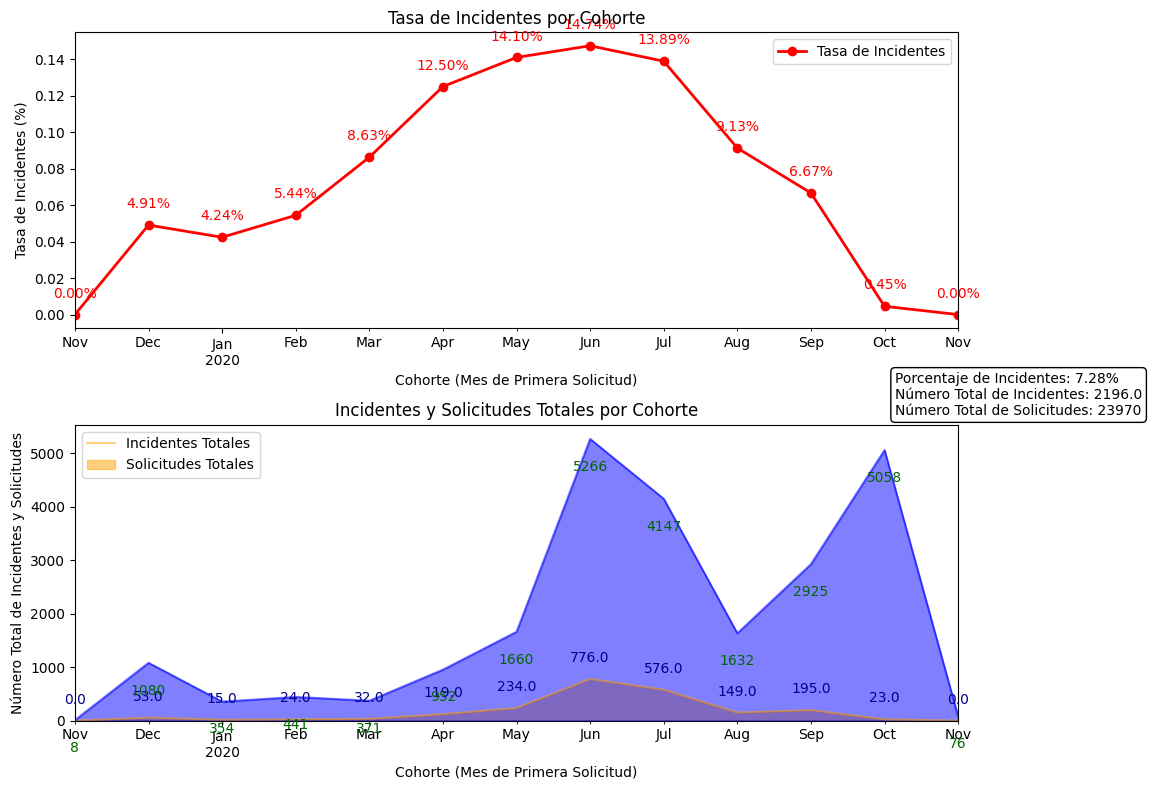

In [4]:
import matplotlib.pyplot as plt

# Crear dos subplots, uno para la tasa de incidentes y otro para las solicitudes totales e incidentes totales
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico para la tasa de incidentes
cohort_incidents['incident_rate'].plot(kind='line', marker='o', ax=ax1, color='red', linewidth=2)
ax1.set_title('Tasa de Incidentes por Cohorte')
ax1.set_xlabel('Cohorte (Mes de Primera Solicitud)')
ax1.set_ylabel('Tasa de Incidentes (%)')
ax1.legend(['Tasa de Incidentes'], loc='upper right')

# Añadir etiquetas de datos para la tasa de incidentes
for i, txt in enumerate(cohort_incidents['incident_rate']):
    ax1.annotate(f'{txt:.2%}', (cohort_incidents.index[i], txt), textcoords="offset points", xytext=(0,10), ha='center', va='bottom', color='red')

# Gráfico para las solicitudes totales e incidentes totales
cohort_incidents[['total_incidents', 'total_requests']].plot(kind='area', stacked=False, ax=ax2, alpha=0.5, color=['orange', 'blue'])
ax2.set_title('Incidentes y Solicitudes Totales por Cohorte')
ax2.set_xlabel('Cohorte (Mes de Primera Solicitud)')
ax2.set_ylabel('Número Total de Incidentes y Solicitudes')
ax2.legend(['Incidentes Totales', 'Solicitudes Totales'], loc='upper left')

# Añadir etiquetas de datos para las áreas de incidentes y solicitudes
incident_values = cohort_incidents['total_incidents'].tolist()
request_values = cohort_incidents['total_requests'].tolist()

for i, (inc_val, req_val) in enumerate(zip(incident_values, request_values)):
    ax2.annotate(f'{inc_val}', (cohort_incidents.index[i], inc_val), textcoords="offset points", xytext=(0,10), ha='center', va='bottom', color='darkblue')
    ax2.annotate(f'{req_val}', (cohort_incidents.index[i], req_val), textcoords="offset points", xytext=(0,-15), ha='center', va='top', color='darkgreen')

# Crear una leyenda personalizada en el lado derecho del gráfico
stats_text = f"Porcentaje de Incidentes: {cohort_incidents['incident_rate'].mean():.2%}\n" \
             f"Número Total de Incidentes: {cohort_incidents['total_incidents'].sum()}\n" \
             f"Número Total de Solicitudes: {cohort_incidents['total_requests'].sum()}"

# Añadir el texto como un cuadro de anotación dentro del gráfico
plt.gcf().text(0.9, 0.5, stats_text, fontsize=10, verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.show()


/var/folders/8d/_dfy3v191xq4fpx56kpljr380000gn/T/ipykernel_12325/4250579056.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cash_requests_df['month'] = cash_requests_df['created_at'].dt.to_period('M')


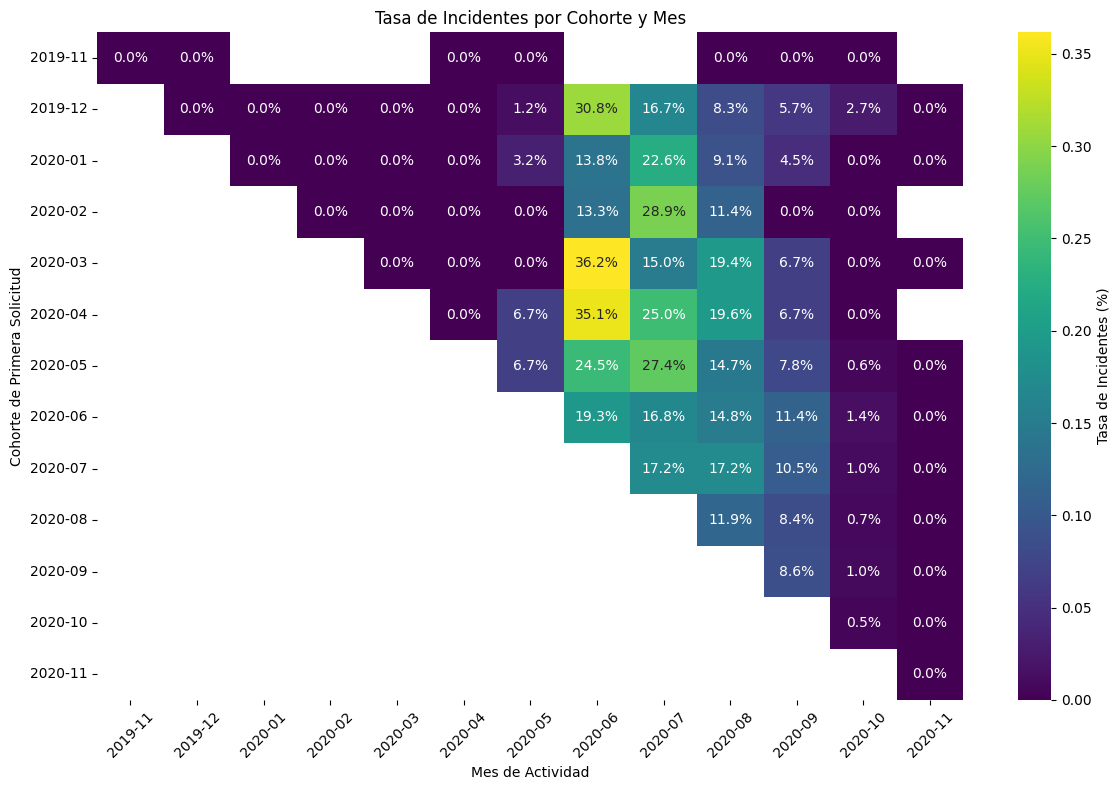

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Añadir una columna 'month' para calcular las tasas de incidentes mensuales
cash_requests_df['month'] = cash_requests_df['created_at'].dt.to_period('M')

# Reagrupar por cohorte y mes
monthly_cohort_data = cash_requests_df.groupby(['cohort', 'month']).agg(
    monthly_incidents=('incident_count', 'sum'),
    monthly_requests=('id', 'count')
)
monthly_cohort_data['monthly_incident_rate'] = monthly_cohort_data['monthly_incidents'] / monthly_cohort_data['monthly_requests']

# Pivotear los datos para el mapa de calor
pivot_table = monthly_cohort_data['monthly_incident_rate'].unstack(level=1)  # Unstack by month

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".1%", cbar_kws={'label': 'Tasa de Incidentes (%)'})
plt.title('Tasa de Incidentes por Cohorte y Mes')
plt.xlabel('Mes de Actividad')
plt.ylabel('Cohorte de Primera Solicitud')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()